In [8]:
%matplotlib inline
from pyspark import SparkContext, SparkConf
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.regression import LabeledPoint as DataPoint
from pyspark.mllib.tree import RandomForest, DecisionTreeModel
import sys, csv
import numpy as np
from sklearn.metrics import roc_curve
TEST_DATA = "../data/preprocessed_train_5M.csv"
import matplotlib.pyplot as plt

In [2]:
def ParseData(row):
	data = [float(feature) for feature in row.split(",")]
	return DataPoint(data[0], data[1:20])

#if __name__ == "__main__":
	#conf = SparkConf().setAppName("regressiontest").setMaster("org.apache.spark.deploy.master.Master")
	#sc = SparkContext(conf=conf)
data = sc.textFile(TEST_DATA).map(ParseData)
train, test = data.randomSplit([0.6, 0.4], seed = 11L)

RF = RandomForest.trainClassifier(train, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=10, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=5, maxBins=32)

predictions = RF.predict(test.map(lambda x: x.features))
labelsAndPredictions = test.map(lambda lp: lp.label).zip(predictions)

testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(test.count())
print testErr

0.249192191871


In [11]:
print "OMG RF"
trees = RF._java_model.trees()
ntrees = RF.numTrees()
scores = DecisionTreeModel(trees[0]).predict(test.map(lambda x: x.features))

# For each decision tree, apply its prediction to the entire dataset and
# accumulate the results using 'zip'.
for i in range(1,ntrees):
    dtm = DecisionTreeModel(trees[i])
    scores = scores.zip(dtm.predict(test.map(lambda x: x.features)))
    scores = scores.map(lambda x: max(x[0], x[1]))
scores = scores.map(lambda x: x/ntrees)
labelsAndScores = test.map(lambda lp: lp.label).zip(scores)



OMG RF


In [12]:
print "collect data"
labelsAndScores_list = labelsAndScores.collect()
labelsAndScores_list = np.array(labelsAndScores_list)

collect data


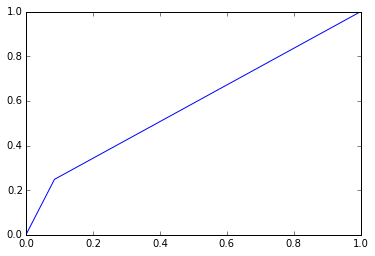

In [13]:
tpr, fpr, th = roc_curve(labelsAndScores_list[:,0].flatten(), labelsAndScores_list[:,1].flatten())
plt.figure(1)
plt.plot(tpr, fpr)